# Artificial Neural Network

After we have quantified microstructural images for each of the materials, we will now perform regression with an artificial neural network. The dataset is the one we have collected using ABAQUS simulations on particulate MMCs. This was the main dataset behind our research paper
First lets import some libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch

from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score

Let's read in an excel file consisting of all the quantified data about the material. Here, the excel file we have consists of both numerical material data about the different phases in the material and also the quantified visual data which was created by the earlier CNN. The ANN and CNN can alternatively be connected via the same pipeline, but we are not doing that here

In [52]:
df = pd.read_excel('Github Data.xlsx', sheet_name = 'ANN Particulate MMC')

We will separate the input features into X and the output features into y. The y can also be any of the other 3 output variables (Yield Strength, UTS, Fracture Strain) from the excel sheet.

In [20]:
columns_to_drop = ['Simulation', 'Young Modulus', 'Yield Strength', 'Ultimate Tensile Strength', 'Fracture Strain', 'Yield Strain']  # Replace with your column names

X = df.drop(columns_to_drop, axis=1)

y = df['Young Modulus']

We will randomly split the data into train, validation and test

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
from sklearn.model_selection import train_test_split

# Step 1: Split data into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

# Step 2: Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)


We will normalize the data

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler()

In [25]:
X_train= scaler.fit_transform(X_train)

In [26]:
X_val = scaler.fit_transform(X_val)

In [27]:
X_test = scaler.transform(X_test)

For any different application, we will have a different set of optimal hyperparameters for the ANN. Lets tune the architecture
and other hyperparameters using a custom random search algorithm. First lets make a function that will randomly try many different combinations of ANN layers, neurons/layer and learning rates. Then we will create an object from the function

In [28]:
# Define a function to build the model
def build_model(hp):
    model = Sequential()
    # Tune the number of layers and neurons in each layer
    for i in range(hp.Int('num_layers', 3, 10)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=5, max_value=100, step=1),
                        activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mse')
    return model

In [29]:
# Instantiate the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train for each trial
    directory='my_dir_combined_YM',
    project_name='combined_YM'
)

Reloading Tuner from my_dir_combined_YM\combined_YM\tuner0.json


In [30]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)

We will now conduct a search. The following line of code may take a long time to complete. We can track how many trials are completed with time. We can also interupt the search and continue at any different time, or just stop prematurely if we have found a good enough combination of hyperparamters.

IF YOU HAVE ALREADY DONE THIS SEARCH EARLIER NO NEED TO RUN IT AGAIN!!!

In [17]:
# Search for the best hyperparameters
tuner.search(
    x=X_train,
    y=y_train.values,
    validation_data=(X_val, y_val.values),
    epochs=1000,
    batch_size=128,
    callbacks=[early_stopping]
)



Search: Running Trial #46

Value             |Best Value So Far |Hyperparameter
9                 |4                 |num_layers
19                |60                |units_0
35                |61                |units_1
57                |57                |units_2
0.001             |0.01              |learning_rate
78                |50                |units_3
94                |18                |units_4
12                |73                |units_5
74                |47                |units_6
77                |97                |units_7
58                |53                |units_8
33                |27                |units_9


Epoch 1/1000

7/7 [==============================] - 3s 68ms/step - loss: 10390646784.0000 - val_loss: 10423647232.0000
Epoch 2/1000
7/7 [==============================] - 0s 27ms/step - loss: 10390520832.0000 - val_loss: 10423393280.0000
Epoch 3/1000
7/7 [==============================] - 0s 19ms/step - loss: 10390054912.0000 - val_loss: 10422455296.000

Epoch 63/1000
7/7 [==============================] - 0s 17ms/step - loss: 27878960.0000 - val_loss: 29646656.0000
Epoch 64/1000
7/7 [==============================] - 0s 19ms/step - loss: 26132658.0000 - val_loss: 29367970.0000
Epoch 65/1000
7/7 [==============================] - 0s 19ms/step - loss: 24878258.0000 - val_loss: 26970874.0000
Epoch 66/1000
7/7 [==============================] - 0s 17ms/step - loss: 23542938.0000 - val_loss: 25448894.0000
Epoch 67/1000
7/7 [==============================] - 0s 20ms/step - loss: 21732848.0000 - val_loss: 25337862.0000
Epoch 68/1000
7/7 [==============================] - 0s 16ms/step - loss: 20392074.0000 - val_loss: 22607548.0000
Epoch 69/1000
7/7 [==============================] - 0s 20ms/step - loss: 19186606.0000 - val_loss: 22308680.0000
Epoch 70/1000
7/7 [==============================] - 0s 17ms/step - loss: 17861636.0000 - val_loss: 20742710.0000
Epoch 71/1000
7/7 [==============================] - 0s 18ms/step - loss: 16757239.0000 

Epoch 136/1000
7/7 [==============================] - 0s 7ms/step - loss: 2948095.7500 - val_loss: 5112500.0000
Epoch 137/1000
7/7 [==============================] - 0s 9ms/step - loss: 2944958.5000 - val_loss: 4539716.5000
Epoch 138/1000
7/7 [==============================] - 0s 7ms/step - loss: 2943744.5000 - val_loss: 4489615.0000
Epoch 139/1000
7/7 [==============================] - 0s 8ms/step - loss: 2906661.5000 - val_loss: 4690528.0000
Epoch 140/1000
7/7 [==============================] - 0s 7ms/step - loss: 2891673.0000 - val_loss: 4528651.0000
Epoch 141/1000
7/7 [==============================] - 0s 6ms/step - loss: 2869592.2500 - val_loss: 4540488.0000
Epoch 142/1000
7/7 [==============================] - 0s 7ms/step - loss: 2845252.0000 - val_loss: 5280665.5000
Epoch 143/1000
7/7 [==============================] - 0s 7ms/step - loss: 2902906.0000 - val_loss: 4593441.0000
Epoch 144/1000
1/7 [===>..........................] - ETA: 0s - loss: 3023011.5000

KeyboardInterrupt: 

We will now retrieve the best set of hyperparameters from the searching we (actually our computer) has automatically done. 
Check the architecture summary below as well.

In [31]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [32]:
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

We will now train the optimal ANN

In [34]:
model.fit(
    x=X_train,
    y=y_train.values,
    validation_data=(X_val, y_val.values),
    epochs=10000,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/10000
7/7 [==============================] - 1s 33ms/step - loss: 10389210112.0000 - val_loss: 10414946304.0000
Epoch 2/10000
7/7 [==============================] - 0s 7ms/step - loss: 10350979072.0000 - val_loss: 10284759040.0000
Epoch 3/10000
7/7 [==============================] - 0s 6ms/step - loss: 10017110016.0000 - val_loss: 9439893504.0000
Epoch 4/10000
7/7 [==============================] - 0s 9ms/step - loss: 8372975104.0000 - val_loss: 6113291776.0000
Epoch 5/10000
7/7 [==============================] - 0s 7ms/step - loss: 3614992896.0000 - val_loss: 298876896.0000
Epoch 6/10000
7/7 [==============================] - 0s 9ms/step - loss: 1027222912.0000 - val_loss: 1126650880.0000
Epoch 7/10000
7/7 [==============================] - 0s 9ms/step - loss: 427157280.0000 - val_loss: 449645472.0000
Epoch 8/10000
7/7 [==============================] - 0s 7ms/step - loss: 558672000.0000 - val_loss: 288541984.0000
Epoch 9/10000
7/7 [==============================] - 0s 7ms/ste

7/7 [==============================] - 0s 5ms/step - loss: 10769821.0000 - val_loss: 14989506.0000
Epoch 73/10000
7/7 [==============================] - 0s 6ms/step - loss: 10048939.0000 - val_loss: 13009526.0000
Epoch 74/10000
7/7 [==============================] - 0s 6ms/step - loss: 9382379.0000 - val_loss: 13781441.0000
Epoch 75/10000
7/7 [==============================] - 0s 6ms/step - loss: 8853401.0000 - val_loss: 11446616.0000
Epoch 76/10000
7/7 [==============================] - 0s 7ms/step - loss: 8164941.5000 - val_loss: 12581658.0000
Epoch 77/10000
7/7 [==============================] - 0s 6ms/step - loss: 7673577.5000 - val_loss: 10307427.0000
Epoch 78/10000
7/7 [==============================] - 0s 6ms/step - loss: 7144403.5000 - val_loss: 10755168.0000
Epoch 79/10000
7/7 [==============================] - 0s 7ms/step - loss: 6706070.0000 - val_loss: 9718924.0000
Epoch 80/10000
7/7 [==============================] - 0s 8ms/step - loss: 6222543.0000 - val_loss: 9754347.000

Epoch 145/10000
7/7 [==============================] - 0s 7ms/step - loss: 2009227.2500 - val_loss: 3609576.5000
Epoch 146/10000
7/7 [==============================] - 0s 7ms/step - loss: 1980165.2500 - val_loss: 3967989.0000
Epoch 147/10000
7/7 [==============================] - 0s 7ms/step - loss: 2028229.3750 - val_loss: 2389493.7500
Epoch 148/10000
7/7 [==============================] - 0s 6ms/step - loss: 1936323.8750 - val_loss: 3633741.7500
Epoch 149/10000
7/7 [==============================] - 0s 6ms/step - loss: 1982679.8750 - val_loss: 3774236.0000
Epoch 150/10000
7/7 [==============================] - 0s 7ms/step - loss: 1979064.8750 - val_loss: 2877004.7500
Epoch 151/10000
7/7 [==============================] - 0s 6ms/step - loss: 1953892.6250 - val_loss: 2577945.2500
Epoch 152/10000
7/7 [==============================] - 0s 8ms/step - loss: 1953836.8750 - val_loss: 3264576.2500
Epoch 153/10000
7/7 [==============================] - 0s 7ms/step - loss: 1940390.2500 - val_lo

7/7 [==============================] - 0s 7ms/step - loss: 1693591.5000 - val_loss: 2368230.5000
Epoch 218/10000
7/7 [==============================] - 0s 6ms/step - loss: 1754978.1250 - val_loss: 3617422.2500
Epoch 219/10000
7/7 [==============================] - 0s 6ms/step - loss: 1682138.6250 - val_loss: 2923882.0000
Epoch 220/10000
7/7 [==============================] - 0s 6ms/step - loss: 1607239.5000 - val_loss: 2629976.7500
Epoch 221/10000
7/7 [==============================] - 0s 8ms/step - loss: 1596740.6250 - val_loss: 2474208.7500
Epoch 222/10000
7/7 [==============================] - 0s 7ms/step - loss: 1610415.3750 - val_loss: 2205741.2500
Epoch 223/10000
7/7 [==============================] - 0s 7ms/step - loss: 1611395.3750 - val_loss: 1905156.1250
Epoch 224/10000
7/7 [==============================] - 0s 6ms/step - loss: 1609862.8750 - val_loss: 2514210.0000
Epoch 225/10000
7/7 [==============================] - 0s 6ms/step - loss: 1575559.1250 - val_loss: 2497458.7500

7/7 [==============================] - 0s 6ms/step - loss: 1392927.3750 - val_loss: 2248180.5000
Epoch 290/10000
7/7 [==============================] - 0s 7ms/step - loss: 1514869.5000 - val_loss: 1852849.2500
Epoch 291/10000
7/7 [==============================] - 0s 6ms/step - loss: 1466139.6250 - val_loss: 1567315.6250
Epoch 292/10000
7/7 [==============================] - 0s 7ms/step - loss: 1448529.5000 - val_loss: 1883875.6250
Epoch 293/10000
7/7 [==============================] - 0s 6ms/step - loss: 1381922.5000 - val_loss: 2182601.0000
Epoch 294/10000
7/7 [==============================] - 0s 6ms/step - loss: 1354467.3750 - val_loss: 2083791.3750
Epoch 295/10000
7/7 [==============================] - 0s 6ms/step - loss: 1349001.8750 - val_loss: 1863617.7500
Epoch 296/10000
7/7 [==============================] - 0s 7ms/step - loss: 1373407.2500 - val_loss: 2271845.0000
Epoch 297/10000
7/7 [==============================] - 0s 7ms/step - loss: 1346360.1250 - val_loss: 2835728.5000

7/7 [==============================] - 0s 6ms/step - loss: 1254413.5000 - val_loss: 2805682.7500
Epoch 362/10000
7/7 [==============================] - 0s 6ms/step - loss: 1381528.2500 - val_loss: 2405255.7500
Epoch 363/10000
7/7 [==============================] - 0s 6ms/step - loss: 1274345.3750 - val_loss: 1498851.1250
Epoch 364/10000
7/7 [==============================] - 0s 8ms/step - loss: 1201482.5000 - val_loss: 2155408.7500
Epoch 365/10000
7/7 [==============================] - 0s 8ms/step - loss: 1187846.0000 - val_loss: 2065992.2500
Epoch 366/10000
7/7 [==============================] - 0s 6ms/step - loss: 1212482.3750 - val_loss: 1514334.1250
Epoch 367/10000
7/7 [==============================] - 0s 6ms/step - loss: 1227163.7500 - val_loss: 1492343.5000
Epoch 368/10000
7/7 [==============================] - 0s 7ms/step - loss: 1269011.0000 - val_loss: 2795008.2500
Epoch 369/10000
7/7 [==============================] - 0s 8ms/step - loss: 1214014.1250 - val_loss: 2439905.5000

7/7 [==============================] - 0s 7ms/step - loss: 1079008.5000 - val_loss: 1951807.6250
Epoch 434/10000
7/7 [==============================] - 0s 6ms/step - loss: 1063730.0000 - val_loss: 1880632.0000
Epoch 435/10000
7/7 [==============================] - 0s 7ms/step - loss: 1061496.5000 - val_loss: 1874578.0000
Epoch 436/10000
7/7 [==============================] - 0s 8ms/step - loss: 1078025.8750 - val_loss: 1529771.1250
Epoch 437/10000
7/7 [==============================] - 0s 6ms/step - loss: 1140261.2500 - val_loss: 2452397.7500
Epoch 438/10000
7/7 [==============================] - 0s 6ms/step - loss: 1274049.8750 - val_loss: 1117164.5000
Epoch 439/10000
7/7 [==============================] - 0s 7ms/step - loss: 1172105.0000 - val_loss: 2451954.0000
Epoch 440/10000
7/7 [==============================] - 0s 6ms/step - loss: 1094705.0000 - val_loss: 1986565.0000
Epoch 441/10000
7/7 [==============================] - 0s 8ms/step - loss: 1147890.2500 - val_loss: 1499572.2500

Epoch 506/10000
7/7 [==============================] - 0s 7ms/step - loss: 1047216.0000 - val_loss: 1681548.0000
Epoch 507/10000
7/7 [==============================] - 0s 7ms/step - loss: 976307.1250 - val_loss: 2187094.5000
Epoch 508/10000
7/7 [==============================] - 0s 7ms/step - loss: 933610.2500 - val_loss: 1809433.1250
Epoch 509/10000
7/7 [==============================] - 0s 6ms/step - loss: 931513.6250 - val_loss: 1407647.3750
Epoch 510/10000
7/7 [==============================] - 0s 7ms/step - loss: 893658.1875 - val_loss: 1129891.1250
Epoch 511/10000
7/7 [==============================] - 0s 7ms/step - loss: 1021908.3125 - val_loss: 1802667.7500
Epoch 512/10000
7/7 [==============================] - 0s 8ms/step - loss: 879343.5625 - val_loss: 1345799.0000
Epoch 513/10000
7/7 [==============================] - 0s 6ms/step - loss: 907725.5625 - val_loss: 2272678.7500
Epoch 514/10000
7/7 [==============================] - 0s 6ms/step - loss: 1003989.5000 - val_loss: 13

Epoch 579/10000
7/7 [==============================] - 0s 7ms/step - loss: 943757.9375 - val_loss: 975348.6875
Epoch 580/10000
7/7 [==============================] - 0s 7ms/step - loss: 1262943.1250 - val_loss: 2705406.5000
Epoch 581/10000
7/7 [==============================] - 0s 7ms/step - loss: 868640.3750 - val_loss: 1482816.0000
Epoch 582/10000
7/7 [==============================] - 0s 8ms/step - loss: 834480.0625 - val_loss: 1390868.0000
Epoch 583/10000
7/7 [==============================] - 0s 7ms/step - loss: 907651.4375 - val_loss: 1792331.2500
Epoch 584/10000
7/7 [==============================] - 0s 7ms/step - loss: 850682.1250 - val_loss: 3629030.0000
Epoch 585/10000
7/7 [==============================] - 0s 6ms/step - loss: 1317479.2500 - val_loss: 2917526.0000
Epoch 586/10000
7/7 [==============================] - 0s 6ms/step - loss: 1421100.1250 - val_loss: 1002887.5000
Epoch 587/10000
7/7 [==============================] - 0s 7ms/step - loss: 1306889.2500 - val_loss: 91

7/7 [==============================] - 0s 6ms/step - loss: 767379.9375 - val_loss: 1411990.3750
Epoch 653/10000
7/7 [==============================] - 0s 6ms/step - loss: 872908.1250 - val_loss: 980035.0625
Epoch 654/10000
7/7 [==============================] - 0s 6ms/step - loss: 1023219.1875 - val_loss: 1138191.8750
Epoch 655/10000
7/7 [==============================] - 0s 6ms/step - loss: 1143087.5000 - val_loss: 1075533.8750
Epoch 656/10000
7/7 [==============================] - 0s 8ms/step - loss: 1001215.8750 - val_loss: 858767.6875
Epoch 657/10000
7/7 [==============================] - 0s 7ms/step - loss: 1095004.7500 - val_loss: 948533.6250
Epoch 658/10000
7/7 [==============================] - 0s 6ms/step - loss: 879640.6250 - val_loss: 1047918.5625
Epoch 659/10000
7/7 [==============================] - 0s 7ms/step - loss: 879368.3125 - val_loss: 1109340.2500
Epoch 660/10000
7/7 [==============================] - 0s 7ms/step - loss: 978734.6250 - val_loss: 1585474.3750
Epoch 6

7/7 [==============================] - 0s 8ms/step - loss: 1597903.8750 - val_loss: 2834944.7500
Epoch 726/10000
7/7 [==============================] - 0s 6ms/step - loss: 1842599.8750 - val_loss: 5079944.0000
Epoch 727/10000
7/7 [==============================] - 0s 8ms/step - loss: 1619595.8750 - val_loss: 5421026.5000
Epoch 728/10000
7/7 [==============================] - 0s 9ms/step - loss: 1423702.2500 - val_loss: 3958178.2500
Epoch 729/10000
7/7 [==============================] - 0s 6ms/step - loss: 1017008.0625 - val_loss: 3057554.7500
Epoch 730/10000
7/7 [==============================] - 0s 7ms/step - loss: 1064017.3750 - val_loss: 4606016.5000
Epoch 731/10000
7/7 [==============================] - 0s 7ms/step - loss: 1531258.7500 - val_loss: 2844105.0000
Epoch 732/10000
7/7 [==============================] - 0s 7ms/step - loss: 1162621.6250 - val_loss: 2723783.2500
Epoch 733/10000
7/7 [==============================] - 0s 6ms/step - loss: 1046656.5625 - val_loss: 2019309.8750

7/7 [==============================] - 0s 7ms/step - loss: 842012.5000 - val_loss: 1230065.7500
Epoch 799/10000
7/7 [==============================] - 0s 7ms/step - loss: 817836.8750 - val_loss: 1047442.5000
Epoch 800/10000
7/7 [==============================] - 0s 6ms/step - loss: 772804.5625 - val_loss: 1566264.5000
Epoch 801/10000
7/7 [==============================] - 0s 7ms/step - loss: 723689.0000 - val_loss: 1821628.8750
Epoch 802/10000
7/7 [==============================] - 0s 7ms/step - loss: 741967.3750 - val_loss: 1782536.5000
Epoch 803/10000
7/7 [==============================] - 0s 8ms/step - loss: 769154.1875 - val_loss: 1488334.0000
Epoch 804/10000
7/7 [==============================] - 0s 6ms/step - loss: 735743.8750 - val_loss: 1602246.8750
Epoch 805/10000
7/7 [==============================] - 0s 7ms/step - loss: 739990.8750 - val_loss: 997691.0625
Epoch 806/10000
7/7 [==============================] - 0s 6ms/step - loss: 835585.1875 - val_loss: 887137.4375
Epoch 807/

Lets check how the loss has evolved to investigate how well the model has trained.

In [35]:
losses = pd.DataFrame(model.history.history)

<Axes: >

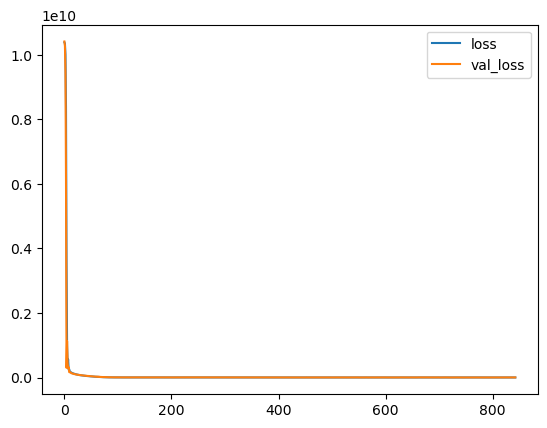

In [36]:
losses.plot()

Lets evaluate the model using some performance metrics. The MAE and MSE are only comprehensible if he get the min, max and average so we find first too.

In [45]:
predictions = model.predict(X_test)
predictions_train = model.predict(X_train)
predictions_val = model.predict(X_val)

6/6 [==============================] - 0s 2ms/step


In [46]:
# Calculate the required statistics
min_value = y_test.min()
max_value = y_test.max()
mean_value = y_test.mean()
median_value = y_test.median()
range_value = max_value - min_value

# Print the results
print("Minimum:", min_value)
print("Maximum:", max_value)
print("Mean:", mean_value)
print("Median:", median_value)
print("Range:", range_value)


Minimum: 78952.4738987287
Maximum: 129617.6016330719
Mean: 102379.62922332347
Median: 102263.0650550127
Range: 50665.1277343432


In [47]:
mean_absolute_error(y_test,predictions)

714.081561220029

In [48]:
np.sqrt(mean_squared_error(y_test,predictions))

961.0228516955268

In [49]:
explained_variance_score(y_test,predictions)

0.992714893369645

In [50]:
r2_score(y_test, predictions)

0.9926204431793038

Lets plot a prediction performance scatterplot

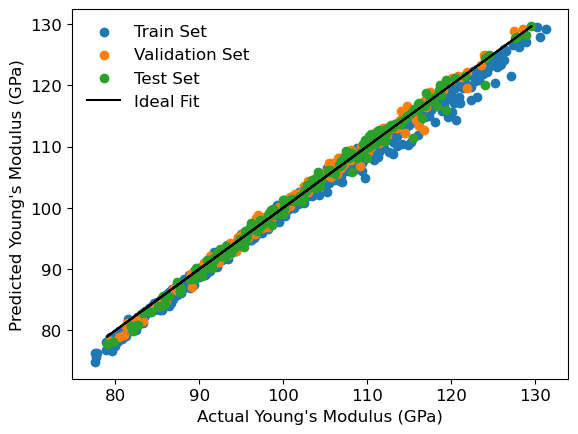

In [51]:
import matplotlib.pyplot as plt

# Assume predictions_train and predictions_val are your prediction arrays for the training and validation sets, respectively

# Our predictions for test, train, and validation sets
plt.scatter(y_train / 1000, predictions_train / 1000, label='Train Set')
plt.scatter(y_val / 1000, predictions_val / 1000, label='Validation Set')
plt.scatter(y_test / 1000, predictions / 1000, label='Test Set')

# Perfect predictions line
plt.plot(y_test / 1000, y_test / 1000, 'black', label='Ideal Fit')

# Adding labels and title for clarity
plt.xlabel("Actual Young's Modulus (GPa)", fontsize=12)
plt.ylabel("Predicted Young's Modulus (GPa)", fontsize=12)
#plt.title('Ductility Prediction Scatterplot')
plt.legend(frameon=False, fontsize=12)

# Adjust the fontsize of xticks and yticks
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

# Show the plot
plt.show()


Thats all for this simple walkthrough of the key points. A lot more can be done as well.